# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.183736,True,4.763822
1,0.420759,True,4.616919
2,0.919566,True,4.528552
3,-0.906746,False,-1.394118
4,-0.963120,False,-0.620770
...,...,...,...
995,0.584039,False,1.094510
996,-0.016755,False,0.362409
997,0.869909,True,6.288171
998,-1.436299,False,-1.565221


<AxesSubplot: xlabel='v0'>

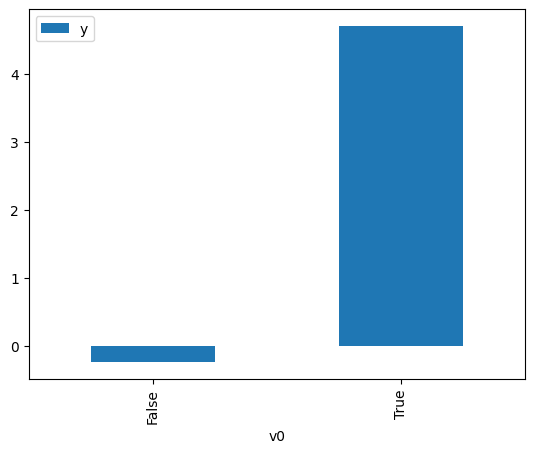

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

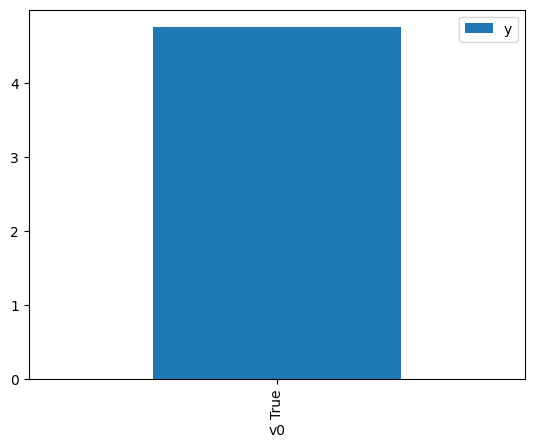

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.704340,False,0.231171,0.724873,1.379551
1,0.188593,False,-0.691065,0.435882,2.294198
2,1.564008,False,1.907280,0.104579,9.562151
3,-0.286544,False,-0.778709,0.597443,1.673800
4,-0.009200,False,1.502131,0.503456,1.986271
...,...,...,...,...,...
995,-0.198716,False,0.669776,0.568116,1.760203
996,-0.633207,False,0.266390,0.704963,1.418513
997,-0.590103,False,-2.566600,0.692500,1.444043
998,-2.145521,False,-1.666335,0.950196,1.052415


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,0.198830,True,4.480957,0.567573,1.761889
1,-1.315712,True,4.574624,0.140804,7.102077
2,-2.014128,True,4.163447,0.059074,16.927879
3,-1.464024,True,4.095279,0.117910,8.481034
4,-1.115808,True,4.210826,0.177407,5.636750
...,...,...,...,...,...
995,-1.110755,True,2.584477,0.178422,5.604678
996,-1.515487,True,3.381962,0.110753,9.029071
997,-1.335706,True,5.998179,0.137514,7.272008
998,-1.110755,True,2.584477,0.178422,5.604678


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.922
Model:                            OLS   Adj. R-squared (uncentered):              0.921
Method:                 Least Squares   F-statistic:                              5863.
Date:                Thu, 26 Jan 2023   Prob (F-statistic):                        0.00
Time:                        16:42:08   Log-Likelihood:                         -1464.8
No. Observations:                1000   AIC:                                      2934.
Df Residuals:                     998   BIC:                                      2943.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.9260      0.033     28.207      0.000       0.862       0.990
x2             4.9738      0.051     96.738      0.000       4.873       5.075
==============================================================================
Omnibus:                        0.097   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.953   Jarque-Bera (JB):                0.148
Skew:                           0.019   Prob(JB):                        0.929
Kurtosis:                       2.954   Cond. No.                         1.64
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""